In [1]:
# Imports
from IPython.core.display import display, HTML
from IPython.display import Image
%matplotlib inline
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
import tensorflow as tf
import ast
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re

/home/pratik/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# WELCOME TO LSTM MODEL

**LSTMs:**

This another popular approach. It does well with short as well as long sentences. It has various architectures which can be used. 

**Embeddings:**
**Word embeddings** can be used. One of the major issues with word embeddings is out of vocabulary words and the memory required to store them. (Especially in cases of entities such as ‘person_name’). Embeddings are created using gensim library.

**Character embeddings** can be used to solve the above problem in which each word is represented by using an embedding layer with one hot representations as input followed by convolutions on them.

**Pretrained Embeddings** can be used. This approach leverages us the capability of transfer learning. These embeddings are trained on wikipedia or various other large generic corpuses hence have a greater insight into the language. We can make use of this insight from huge corpuses just by incorporating the embeddings


**CRF Layer:**
	An additional linear chain CRF can be added at the end of all the layers.



In [2]:
MAX_SEQUENCE_LENGTH = 60
MAX_CHAR_LENGTH = 16
LSTM_UNITS = 64
NUM_CLASSES = 2
EPOCHS = 10
NUM_DIMENSIONS = 100 
BATCH_SIZE = 100
TRAIN_LENGTH = 9000
LSTM_LAYERS = 3
LAYER_PARAMETERS = {'word': True, 'char': False, 'crf': True}
TEST_BATCHES = 10


SAVE_MODEL = 'models/malubu_lstm_context.ckpt'
RAW_DATA_PATH = 'context_data.csv'
WORD_VECTORS_PATH = 'gensim_embeddings_malubu'
WORDS_LIST_PATH = 'gensim_embeddings_malubu_words'

##### MAX_SEQUENCE_LENGTH = The maximum number of tokens in a given sentence
##### MAX_CHAR_LENGTH = Maximum character length of each token
##### LSTM_UNITS = Number of forward and backward lstm units
##### NUM_CLASSES = Number of output classes
##### EPOCHS = Number of epochs
##### NUM_DIMENSIONS = Number of Dimensions of the word embeddings 
##### BATCH_SIZE = The size of the batches
##### TRAIN_LENGTH = The length of the training set(Here we have cons.idered 2500 out of 3500)
##### LSTM_LAYERS = The number of Deep LSTM layers
##### LAYER_PARAMETERS = It allows you to switch on and of the 1.word_embedding layer 2.character_embedding  layer 3. crf layer
##### TEST_BATCHES = Number of Test Batches
##### SAVE_MODEL = The path where you wish to save your model
##### RAW_DATA_PATH = The path of the data
##### WORD_VECTORS_PATH = The path where your word vectors are stored
##### WORDS_LIST_PATH = The path where your vocab is stored

**NOTE: These are the only variables you are allowed and sufficient to change in this NOTEBOOK. Do not change any other parameters**

----------------------------------------------------------------------------------------------------
### LSTM CLASS
This is the main class which we will be using to train test and analyize our model. This is a fairly long piece of code for one class as a lot of preprocessing is required to get data into the lstm model and data visualization.

The architecture shown above is implemented in the class along with customization options.

In [3]:
# Imports
from IPython.core.display import display, HTML
from IPython.display import Image
%matplotlib inline
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
import tensorflow as tf
import ast
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re



class CrfLstmModel(object):

    def __init__(self, max_sequence_length, max_char_length, lstm_units, num_classes, epochs,
                 num_dimensions, batch_size, train_len, lstm_layers, layer_parameters,
                 test_batches, save_model, raw_data_path, word_vectors_path, words_list_path):
        self.max_sequence_length = max_sequence_length
        self.max_char_length = max_char_length
        self.char_vocab = []
        self.lstm_units = lstm_units
        self.num_classes = num_classes
        self.epochs = epochs
        self.num_dimensions = num_dimensions
        self.batch_size = batch_size
        self.train_len = train_len
        self.lstm_layers = lstm_layers
        self.layer_parameters = layer_parameters
        self.test_batches = test_batches

        self.word_vectors_path = word_vectors_path
        self.words_list_path = words_list_path
        self.save_model = save_model
        self.raw_data_path = raw_data_path

        self.raw_data = None
        self.X_train_body = None
        self.y_train = None
        self.X_test_body = None
        self.y_test = None
        self.ids_char_train_body = None
        self.ids_char_test_body = None

        self.X_train_context = None
        self.y_train = None
        self.X_test_context = None
        self.y_test = None
        self.ids_char_train_context = None
        self.ids_char_test_context = None

        self.fin_pred = None

    def load_external_word_embeddings(self, word_vectors_path, words_list_path):
        file_handler = open(self.word_vectors_path, 'rb')
        word_vectors = pickle.load(file_handler)
        file_handler = open(self.words_list_path, 'rb')
        words_list = pickle.load(file_handler)

        return word_vectors, words_list

    def load_raw_data(self, raw_data_path):
        raw_data = pd.read_csv(raw_data_path)
        raw_data['original_text'] = raw_data['original_text'].apply(lambda x: self.convert_to_list(x))
        self.raw_data = raw_data
        return raw_data

    @staticmethod
    def convert_to_list(original_text_string):
        original_text_list = ast.literal_eval(original_text_string)
        original_text_list = [original_text.strip() for original_text in original_text_list]
        return original_text_list

    def generate_y(self, text, original_text_list):
        y = np.zeros([self.max_sequence_length, 2])
        try:
            for i in range(len(y)):
                y[i][0] = 1
            for original_text_words in original_text_list:
                for original_text in word_tokenize(original_text_words):
                    words = word_tokenize(text)
                    for i in range(len(words)):
                        if words[i].lower() == original_text.lower():
                            y[i][1] = 1
                            y[i][0] = 0
        except ValueError:
            # print(ValueError)
            pass
        return y

    def assign_y(self, raw_data):
        y_list = np.zeros([len(raw_data), self.max_sequence_length, 2])
        for body, original_text_list, i in zip(raw_data['body'], raw_data['original_text'], range(len(raw_data))):
            try:
                y_list[i] = self.generate_y(body, original_text_list)
            except IndexError as e:
                # print(e)
                pass
        return y_list

    def generate_ids(self, raw_data, words_list, column_name):
        #added column name
        num_files = len(raw_data)
        ids = np.zeros((num_files, self.max_sequence_length), dtype='int32')
        file_counter = 0
        for line in raw_data[column_name]:
            split = word_tokenize(str(line))
            index_counter = 0
            for word in split:
                try:
                    ids[file_counter][index_counter] = words_list.index(word.lower())
                except ValueError:
                    ids[file_counter][index_counter] = len(words_list) - 2  # Vector for unkown words
                index_counter = index_counter + 1
                if index_counter >= self.max_sequence_length:
                    break
            file_counter = file_counter + 1

        return ids

    def get_character_set(self, text):
        for char in text:
            if char not in self.char_vocab:
                self.char_vocab.append(char)

    def generate_char_ids(self, raw_data, column_name):
        # added column name
        char_one_hot = np.zeros([len(self.char_vocab), len(self.char_vocab)])

        for i in range(len(self.char_vocab)):
            char_one_hot[i][i] = 1

        ids_char = np.zeros([(len(raw_data)), self.max_sequence_length, self.max_char_length])
        ids_char = ids_char + len(self.char_vocab) - 1

        for i in range(len(raw_data)):
            body = str(raw_data.iloc[i][column_name])
            words = word_tokenize(body)
            for j in (range(len(words))):
                word = words[j]
                for k in range(len(word)):
                    char = word[k]
                    try:
                        ids_char[i][j][k] = self.char_vocab.index(char)
                    except (IndexError, ValueError) as e:
                        # print(e)
                        pass

        return char_one_hot, ids_char

    def data_format(self, raw_data_path, word_vectors_path, words_list_path):
        # Fetch word_vectors and wordslist
        word_vectors, words_list = self.load_external_word_embeddings(self.word_vectors_path, self.words_list_path)

        # Fetch raw_data
        raw_data = self.load_raw_data(raw_data_path)

        # Character pre_processing
        raw_data['body'].apply(lambda x: self.get_character_set(str(x)))
        raw_data['context'].apply(lambda x: self.get_character_set(str(x)))
        # Obtain y
        y_list = self.assign_y(raw_data)

        # Generate ids for X
        ids_body = self.generate_ids(raw_data=raw_data, words_list=words_list, column_name='body')
        ids_context = self.generate_ids(raw_data=raw_data, words_list=words_list, column_name='context')

        char_one_hot_body, ids_char_body = self.generate_char_ids(raw_data=raw_data, column_name='body')
        char_one_hot_context, ids_char_context = self.generate_char_ids(raw_data=raw_data, column_name='context')

        return word_vectors, words_list, ids_body, ids_context, y_list, char_one_hot_body, char_one_hot_context, ids_char_body, ids_char_context

    def split_train_test(self, ids_body,ids_context,y_list, ids_char_body, ids_char_context):
        # added body and context
        # print('ids', ids)
        X_train_body = ids_body[:self.train_len]
        X_train_context = ids_context[:self.train_len]
        y_train = y_list[:self.train_len]
        X_test_body = ids_body[self.train_len:]
        X_test_context = ids_context[self.train_len:]
        y_test = y_list[self.train_len:]
        ids_char_train_body = ids_char_body[:self.train_len]
        ids_char_train_context = ids_char_context[:self.train_len]
        ids_char_test_body = ids_char_body[self.train_len:]
        ids_char_test_context = ids_char_context[self.train_len:]

        # print('x_train', X_train)
        return X_train_body, X_train_context, y_train, X_test_body, X_test_context,\
               y_test, ids_char_train_body, ids_char_train_context, ids_char_test_body, ids_char_test_context

    def architecture(self, labels, input_data_body, input_data_context, char_input_data_body, char_input_data_context, train=True):


        with tf.variable_scope("architecture", reuse=tf.AUTO_REUSE):
            n_nodes_hl1_body = 40
            weights_body = {'W_conv1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
                       'W_conv2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
                       'W_fc': tf.Variable(tf.random_normal([(int(10 // 2)) * (int(4 // 2)) * 32, 100])),
                       'out': tf.Variable(tf.random_normal([100, 10]))}

            biases_body = {'b_conv1': tf.Variable(tf.random_normal([32])),
                      'b_conv2': tf.Variable(tf.random_normal([64])),
                      'b_fc': tf.Variable(tf.random_normal([100])),
                      'out': tf.Variable(tf.random_normal([10]))}

            hidden_1_layer_body = {
                'weights': tf.Variable(tf.random_normal([1216, n_nodes_hl1_body])),
                'biases': tf.Variable(tf.random_normal([n_nodes_hl1_body]))}

            n_nodes_hl1_context = 40
            weights_context = {'W_conv1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
                       'W_conv2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
                       'W_fc': tf.Variable(tf.random_normal([(int(10 // 2)) * (int(4 // 2)) * 32, 100])),
                       'out': tf.Variable(tf.random_normal([100, 10]))}

            biases_context = {'b_conv1': tf.Variable(tf.random_normal([32])),
                      'b_conv2': tf.Variable(tf.random_normal([64])),
                      'b_fc': tf.Variable(tf.random_normal([100])),
                      'out': tf.Variable(tf.random_normal([10]))}

            hidden_1_layer_context = {
                'weights': tf.Variable(tf.random_normal([1216, n_nodes_hl1_context])),
                'biases': tf.Variable(tf.random_normal([n_nodes_hl1_context]))}





            word_vectors, words_list, ids_body, ids_context, y_list, char_one_hot_body, char_one_hot_context, ids_char_body, ids_char_context = self.data_format(
                raw_data_path=self.raw_data_path,
                word_vectors_path=self.word_vectors_path,
                words_list_path=self.words_list_path)

            fw_cell3_context = tf.nn.rnn_cell.MultiRNNCell(
                [tf.nn.rnn_cell.BasicLSTMCell(self.lstm_units, state_is_tuple=True, reuse=tf.AUTO_REUSE) for _ in
                 range(self.lstm_layers)])

            bw_cell3_context = tf.nn.rnn_cell.MultiRNNCell(
                [tf.nn.rnn_cell.BasicLSTMCell(self.lstm_units, state_is_tuple=True, reuse=tf.AUTO_REUSE) for _ in
                 range(self.lstm_layers)])

            fw_cell3_body = tf.nn.rnn_cell.MultiRNNCell(
                [tf.nn.rnn_cell.BasicLSTMCell(self.lstm_units, state_is_tuple=True, reuse=tf.AUTO_REUSE) for _ in
                 range(self.lstm_layers)])
            print(fw_cell3_body.state_size, 'state_size')
            bw_cell3_body = tf.nn.rnn_cell.MultiRNNCell(
                [tf.nn.rnn_cell.BasicLSTMCell(self.lstm_units, state_is_tuple=True, reuse=tf.AUTO_REUSE) for _ in
                 range(self.lstm_layers)])

            # print('out ids', ids)

            self.X_train_body, self.X_train_context, self.y_train, self.X_test_body, self.X_test_context, \
            self.y_test, self.ids_char_train_body, self.ids_char_train_context, self.ids_char_test_body, self.ids_char_test_context = self.split_train_test(ids_body,ids_context,y_list, ids_char_body,ids_char_context)

            def character_level_embedding_body(char_input):
                char_input = tf.cast(char_input, dtype=tf.int32)
                char_one_hot_tensor = tf.convert_to_tensor(char_one_hot_body, dtype=tf.int32)
                char_data = tf.nn.embedding_lookup(char_one_hot_tensor, char_input)
                keep_rate = 1
                x = tf.cast(
                    tf.reshape(char_data,
                               shape=[self.max_sequence_length, self.max_char_length * len(self.char_vocab)]),
                    dtype=tf.float32)

                def embedding_layer(data_fun):
                    print(data_fun.shape)
                    print(hidden_1_layer_body['weights'].shape)
                    l1 = tf.add(tf.tensordot(data_fun, hidden_1_layer_body['weights'], axes=1), hidden_1_layer_body['biases'])
                    l1 = tf.nn.relu(l1)
                    # print(l1.shape)
                    return l1

                def conv2d(x_fun, w_fun):
                    return tf.nn.conv2d(x_fun, w_fun, strides=[1, 1, 1, 1], padding='SAME')

                def maxpool2d(x_fun):
                    #                        size of window         movement of window
                    return tf.nn.max_pool(x_fun, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

                def convolutional_neural_network(x_fun):
                    x_fun = tf.reshape(x_fun, shape=[self.max_sequence_length, 10, 4, 1])
                    conv1 = tf.nn.relu(conv2d(x_fun, weights_body['W_conv1']) + biases_body['b_conv1'])
                    conv2 = maxpool2d(conv1)
                    fc = tf.reshape(conv2, [self.max_sequence_length, (10 // 2) * (4 // 2) * 32])
                    fc = tf.nn.relu(tf.matmul(fc, weights_body['W_fc']) + biases_body['b_fc'])
                    fc = tf.nn.dropout(fc, keep_rate)
                    return fc

                def train_neural_network(x_fun):
                    print('x_fun', x_fun.shape)
                    embedded_x = embedding_layer(x_fun)
                    convoluted_x = convolutional_neural_network(embedded_x)
                    return convoluted_x

                char_data = train_neural_network(x)
                return char_data

            def character_level_embedding_context(char_input_context):
                char_input_context = tf.cast(char_input_context, dtype=tf.int32)
                char_one_hot_tensor = tf.convert_to_tensor(char_one_hot_context, dtype=tf.int32)
                char_data = tf.nn.embedding_lookup(char_one_hot_tensor, char_input_context)
                keep_rate = 1
                x = tf.cast(
                    tf.reshape(char_data,
                               shape=[self.max_sequence_length, self.max_char_length * len(self.char_vocab)]),
                    dtype=tf.float32)

                def embedding_layer(data_fun):
                    print(data_fun.shape)
                    print(hidden_1_layer_context['weights'].shape)
                    l1 = tf.add(tf.tensordot(data_fun, hidden_1_layer_context['weights'], axes=1), hidden_1_layer_context['biases'])
                    l1 = tf.nn.relu(l1)
                    # print(l1.shape)
                    return l1

                def conv2d(x_fun, w_fun):
                    return tf.nn.conv2d(x_fun, w_fun, strides=[1, 1, 1, 1], padding='SAME')

                def maxpool2d(x_fun):
                    #                        size of window         movement of window
                    return tf.nn.max_pool(x_fun, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

                def convolutional_neural_network(x_fun):
                    x_fun = tf.reshape(x_fun, shape=[self.max_sequence_length, 10, 4, 1])
                    conv1 = tf.nn.relu(conv2d(x_fun, weights_context['W_conv1']) + biases_context['b_conv1'])
                    conv2 = maxpool2d(conv1)
                    fc = tf.reshape(conv2, [self.max_sequence_length, (10 // 2) * (4 // 2) * 32])
                    fc = tf.nn.relu(tf.matmul(fc, weights_context['W_fc']) + biases_context['b_fc'])
                    fc = tf.nn.dropout(fc, keep_rate)
                    return fc

                def train_neural_network(x_fun):
                    print('x_fun', x_fun.shape)
                    embedded_x = embedding_layer(x_fun)
                    convoluted_x = convolutional_neural_network(embedded_x)
                    return convoluted_x

                char_data = train_neural_network(x)
                return char_data




            def char_embeddings_layer_body(char_input):
                print('ci', char_input.shape)
                char_embeddings_fun = tf.map_fn(lambda x: character_level_embedding_body(x), char_input, dtype=tf.float32)
                print('cef', char_embeddings_fun.shape)
                return char_embeddings_fun

            def char_embeddings_layer_context(char_input):
                print('ci', char_input.shape)
                char_embeddings_fun = tf.map_fn(lambda x: character_level_embedding_context(x), char_input, dtype=tf.float32)
                print('cef', char_embeddings_fun.shape)
                return char_embeddings_fun


            def word_embeddings_layer_body(input_data_fun):
                word_vectors_fun = tf.convert_to_tensor(word_vectors, dtype=tf.float32)
                data_fun = tf.nn.embedding_lookup(word_vectors_fun, input_data_fun)
                return data_fun

            def word_embeddings_layer_context(input_data_fun):
                word_vectors_fun = tf.convert_to_tensor(word_vectors, dtype=tf.float32)
                data_fun = tf.nn.embedding_lookup(word_vectors_fun, input_data_fun)
                return data_fun


            def char_word_embeddings_body(data_fun, char_embeddings_fun):
                data2_fun = tf.concat([data_fun, char_embeddings_fun], axis=2)
                return data2_fun

            def char_word_embeddings_context(data_fun, char_embeddings_fun):
                data2_fun = tf.concat([data_fun, char_embeddings_fun], axis=2)
                return data2_fun


            def crf_layer_body(p2_fun, prediction_fun, sequence_lengths_fun, transition_params):

                log_likelihood, transition_params_fun = tf.contrib.crf.crf_log_likelihood(
                    inputs=prediction_fun,
                    sequence_lengths=sequence_lengths_fun,
                    tag_indices=p2_fun,
                    transition_params=transition_params)
                crf_loss = tf.reduce_mean(-log_likelihood)

                return crf_loss, transition_params_fun

            data_body = None
            data_context = None
            char_embeddings_body = None
            char_embeddings_context = None
            data2_body = None
            data2_context = None
            transition_params_temp_body = tf.Variable(tf.random_normal([self.num_classes, self.num_classes]))

            if self.layer_parameters['word']:
                data_body = word_embeddings_layer_body(input_data_body)
                data_context = word_embeddings_layer_context(input_data_context)
                data2_body = data_body
                data2_context = data_context

            if self.layer_parameters['char']:
                char_embeddings_body = char_embeddings_layer_body(char_input_data_body)
                data2_body = char_embeddings_body
                char_embeddings_context = char_embeddings_layer_context(char_input_data_context)
                data2_context = char_embeddings_context


            if self.layer_parameters['word'] and self.layer_parameters['char']:
                data2_body = char_word_embeddings_body(data_fun=data_body, char_embeddings_fun=char_embeddings_body)
                data2_context = char_word_embeddings_context(data_fun=data_context, char_embeddings_fun=char_embeddings_context)

            outputs_context, value2_context = tf.nn.bidirectional_dynamic_rnn(fw_cell3_context, bw_cell3_context,
                                                                              data2_context, dtype=tf.float32)
            #last = tf.gather(value, int(outputs_context.get_shape()[0]) - 1)
            #print(last.shoutputsape,'last')
            outputs_body, value2_body = tf.nn.bidirectional_dynamic_rnn(fw_cell3_body, bw_cell3_body, data2_body, initial_state_fw=value2_context[0],dtype=tf.float32)
            #print(outputs_body.shape, 'out')
            outputs_body = tf.concat(outputs_body, 2)
            print(outputs_body.shape, 'outc')



            weight_body = tf.Variable(tf.truncated_normal([self.lstm_units * 2, self.num_classes]))
            bias_body = tf.Variable(tf.constant(0.1, shape=[self.batch_size, self.max_sequence_length, self.num_classes]))

            prediction = (tf.tensordot(outputs_body, weight_body, axes=((2,), (0,))) + bias_body)
            p2 = tf.argmax(labels, axis=2)
            prediction = tf.cast(prediction, dtype=tf.float32)
            p2 = tf.cast(p2, dtype=tf.int32)


            if self.layer_parameters['crf']:
                sequence_lengths = tf.constant(shape=[self.batch_size],
                                               value=np.zeros(self.batch_size) + self.max_sequence_length,
                                               dtype=tf.int32)

                loss, transition_params = crf_layer_body(sequence_lengths_fun=sequence_lengths, prediction_fun=prediction,
                                                    p2_fun=p2, transition_params=transition_params_temp_body)

            else:
                loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=labels))

            optimizer = tf.train.AdamOptimizer().minimize(loss)

            return optimizer, loss, weights_body, weights_context, biases_body, biases_context, \
                   hidden_1_layer_body, hidden_1_layer_context, fw_cell3_body,fw_cell3_context, \
                   bw_cell3_body, bw_cell3_context, prediction, transition_params

    def get_train_batch(self, j):
        i = j * self.batch_size
        arr_body = self.X_train_body[i:i + self.batch_size]
        arr_context = self.X_train_context[i:i + self.batch_size]
        labels = self.y_train[i:i + self.batch_size]
        arr_char_body = self.ids_char_train_body[i:i + self.batch_size]
        arr_char_context = self.ids_char_train_context[i:i + self.batch_size]
        return arr_body, arr_context, labels, arr_char_body, arr_char_context

    def get_test_batch(self, j):
        i = j * self.batch_size
        arr_body = self.X_test_body[i:i + self.batch_size]
        arr_context = self.X_test_context[i:i + self.batch_size]
        labels = self.y_test[i:i + self.batch_size]
        arr_char_body = self.ids_char_test_body[i:i + self.batch_size]
        arr_char_context = self.ids_char_test_context[i:i + self.batch_size]
        return arr_body, arr_context, labels, arr_char_body, arr_char_context


    def train_test_architecture(self):

        labels = tf.placeholder(tf.float32, [self.batch_size, self.max_sequence_length, self.num_classes])
        input_data_body = tf.placeholder(tf.int32, [self.batch_size, self.max_sequence_length])
        char_input_body = tf.placeholder(dtype=tf.float32,
                                         shape=[self.batch_size, self.max_sequence_length, self.max_char_length])

        input_data_context = tf.placeholder(tf.int32, [self.batch_size, self.max_sequence_length])
        char_input_context = tf.placeholder(dtype=tf.float32,
                                         shape=[self.batch_size, self.max_sequence_length, self.max_char_length])

        optimizer, loss, weights_body, weights_context, biases_body, biases_context, \
        hidden_1_layer_body, hidden_1_layer_context, fw_cell3_body, fw_cell3_context, \
        bw_cell3_body, bw_cell3_context, prediction, transition_params = \
            self.architecture(
                labels, input_data_body, input_data_context, char_input_body, char_input_context, train=True)

        init_g = tf.global_variables_initializer()
        init_l = tf.local_variables_initializer()
        init = tf.initialize_all_variables()
        
        fin_pred = np.zeros([self.test_batches * self.batch_size, self.max_sequence_length, 1])
        
        with tf.Session() as sess:
            sess.run(init_g)
            sess.run(init_l)
            sess.run(init)
            saver = tf.train.Saver()
            for i in range(self.epochs):
                print("epoch:  " + str(i))
                losses = 0
                for j in range(self.train_len // self.batch_size):
                    next_batch_body, next_batch_context, next_batch_labels, next_chars_body, next_chars_context = self.get_train_batch(j)
                    #print(next_batch_body.shape, next_batch_context.shape, next_batch_labels.shape, next_chars_body.shape, next_chars_context.shape)
                    _, ll = sess.run([optimizer, loss],
                                     {input_data_body: next_batch_body,
                                      input_data_context: next_batch_context,
                                      labels: next_batch_labels,
                                      char_input_body: next_chars_body,
                                      char_input_context :next_chars_context})
                    losses += ll
                save_path = saver.save(sess, self.save_model)
                print("saved to %s" % save_path)
                print(losses)
                
            for j in range(self.test_batches):
                jj = j * self.batch_size
                next_batch_body, next_batch_context, next_batch_labels, next_chars_body, next_chars_context = self.get_test_batch(j)
                #print(next_batch_body.shape, next_batch_context.shape, next_batch_labels.shape, next_chars_body.shape, next_chars_context.shape)
                p, t = sess.run([prediction, transition_params],
                                {input_data_body: next_batch_body,
                                      input_data_context: next_batch_context,
                                      labels: next_batch_labels,
                                      char_input_body: next_chars_body,
                                      char_input_context :next_chars_context})
            
                for k in range(self.batch_size):
                    viterbi_sequence, viterbi_score = tf.contrib.crf.viterbi_decode(p[k], t)
                    viterbi_sequence = np.array(viterbi_sequence).reshape(self.max_sequence_length, 1)
                    fin_pred[jj:jj + 100][k] = viterbi_sequence

        prediction_analysis = {'expected': [], 'predicted': [], 'body': []}

        for i in range((self.test_batches * self.batch_size)):
            body = word_tokenize(str(self.raw_data[self.train_len:].iloc[i]['body']))
            lab_index_test = np.where(np.argmax(self.y_test, axis=2)[i] == 1)[0]
            lab_index_pred = np.where(fin_pred[i] == 1)[0]
            original_text = []
            pred_original_text = []
            for j in lab_index_test:
                original_text.append(body[j])
            for j in lab_index_pred:
                try:
                    pred_original_text.append(body[j])
                except IndexError:
                    pass
            prediction_analysis['expected'].append(original_text)
            prediction_analysis['predicted'].append(pred_original_text)
            prediction_analysis['body'].append(body)
        prediction_analysis_pandas = pd.DataFrame.from_dict(prediction_analysis)

        return prediction_analysis_pandas

    def prediction_pandas(self):
        fin_pred = self.test_architecture()
        prediction_analysis = {'expected': [], 'predicted': [], 'body': []}
        for i in range((self.test_batches * self.batch_size)):

            body = word_tokenize(str(self.raw_data[self.train_len:].iloc[i]['body']))
            lab_index_test = np.where(np.argmax(self.y_test, axis=2)[i] == 1)[0]
            lab_index_pred = np.where(fin_pred[i] == 1)[0]
            original_text = []
            pred_original_text = []
            for j in lab_index_test:
                original_text.append(body[j])
            for j in lab_index_pred:
                try:
                    pred_original_text.append(body[j])
                except IndexError:
                    pass
            prediction_analysis['expected'].append(original_text)
            prediction_analysis['predicted'].append(pred_original_text)
            prediction_analysis['body'].append(body)
        prediction_analysis_pandas = pd.DataFrame.from_dict(prediction_analysis)
        return prediction_analysis_pandas

    def get_prediction_analysis(prediction_analysis):

        #         prediction_analysis = self.get_predictions(data)
        tp = []
        fp = []
        fn = []
        for predicted, expected in zip(prediction_analysis['predicted'], prediction_analysis['expected']):
            predicted = set([x.lower() for x in predicted])
            expected = set([y.lower() for x in expected for y in word_tokenize(x)])

            tp.append(predicted.intersection(expected))
            fp.append(predicted - predicted.intersection(expected))
            fn.append(expected - predicted.intersection(expected))

        prediction_analysis['tp'] = list(tp)
        prediction_analysis['fp'] = list(fp)
        prediction_analysis['fn'] = list(fn)

        return prediction_analysis
        # pp = tru_pos / (tru_pos + fals_pos)
        # rr = tru_pos / (tru_pos + fals_neg)


### Training
 This is where you create an instance of the class.
 
 And run and obtain the test results using train_test_architecture
 
 get_pred_analysis is used to get the result in a proper format

In [4]:
%%time
model = CrfLstmModel( max_sequence_length=MAX_SEQUENCE_LENGTH, 
                     max_char_length=MAX_CHAR_LENGTH,
                     lstm_units=LSTM_UNITS,
                     num_classes=NUM_CLASSES, 
                     epochs=EPOCHS,
                     num_dimensions=NUM_DIMENSIONS,
                     batch_size=BATCH_SIZE,
                     train_len=TRAIN_LENGTH,
                     lstm_layers=LSTM_LAYERS,
                     layer_parameters=LAYER_PARAMETERS,
                 test_batches=TEST_BATCHES,
                    save_model=SAVE_MODEL
                     , raw_data_path=RAW_DATA_PATH,
                     word_vectors_path=WORD_VECTORS_PATH,
                     words_list_path=WORDS_LIST_PATH)
# word_vectors, words_list, ids_body, ids_context, y_list, char_one_hot_body, char_one_hot_context, ids_char_body, ids_char_context = model.data_format(
#                 raw_data_path=RAW_DATA_PATH,
#                 word_vectors_path=WORD_VECTORS_PATH,
#                 words_list_path=WORDS_LIST_PATH)

#model.train_architecture()
jj2 = model.train_test_architecture()
jj = CrfLstmModel.get_prediction_analysis(jj2)

(LSTMStateTuple(c=64, h=64), LSTMStateTuple(c=64, h=64), LSTMStateTuple(c=64, h=64)) state_size
(100, 60, 128) outc
Instructions for updating:
Use `tf.global_variables_initializer` instead.
epoch:  0
saved to models/malubu_lstm_context.ckpt
690.4310367107391
epoch:  1
saved to models/malubu_lstm_context.ckpt
223.68078672885895
epoch:  2
saved to models/malubu_lstm_context.ckpt
189.3860000371933
epoch:  3
saved to models/malubu_lstm_context.ckpt
153.92228317260742
epoch:  4
saved to models/malubu_lstm_context.ckpt
130.90710574388504
epoch:  5
saved to models/malubu_lstm_context.ckpt
92.55220985412598
epoch:  6
saved to models/malubu_lstm_context.ckpt
74.54921358823776
epoch:  7
saved to models/malubu_lstm_context.ckpt
68.68660125136375
epoch:  8
saved to models/malubu_lstm_context.ckpt
63.67978489398956
epoch:  9
saved to models/malubu_lstm_context.ckpt
59.69865769147873
CPU times: user 15min 57s, sys: 2min 13s, total: 18min 10s
Wall time: 5min 31s


In [5]:
# model.X_train_body, model.X_train_context, model.y_train, model.X_test_body, model.X_test_context, \
# model.y_test, model.ids_char_train_body, model.ids_char_train_context, model.ids_char_test_body, model.ids_char_test_context = model.split_train_test(ids_body,ids_context,y_list, ids_char_body, ids_char_context)
#CPU times: user 29min 5s, sys: 4min 11s, total: 33min 17s
#Wall time: 10min 44s


word_vectors

In [6]:
#model.test_architecture()
#model.prediction_pandas()
#model = CrfLstmModel(layer_parameters=layer_parameters)
#model.prediction_pandas_analysis()
#model.prediction_pandas_analysis()
#jj2 = model.prediction_pandas()


**fp_analysis** consists of the false positive examples

**fn_analysis**  consists of the false negative examples

In [7]:
fp_analysis = jj[(jj['fp']!=set())]
fn_analysis = jj[(jj['fn']!=set())]

Some PreProcessing

In [8]:
X_plot_test = model.raw_data[model.train_len:]
def separate(original_text_list):
    return [each for original_text in original_text_list for each in word_tokenize(original_text) ]

X_plot_test['original_text'] = X_plot_test['original_text'].apply(lambda x: separate(x))  


/home/pratik/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


## Welcome to result Visualisation
Kindly do not try to dig deep into the code as it is not optimized and a little messy **:(** . 

Take insights from the graphs plotted for you. An explaination for each plot is provided.

For good visualization just mute out the code blocks

**Each plot consists of three graphs illustrating the False Positives, False Negatives, Test Data in that respective order

### PLOT 1
#### This plot gives us confusion matrix distribution

360 106 129 497
0.7539267015706806


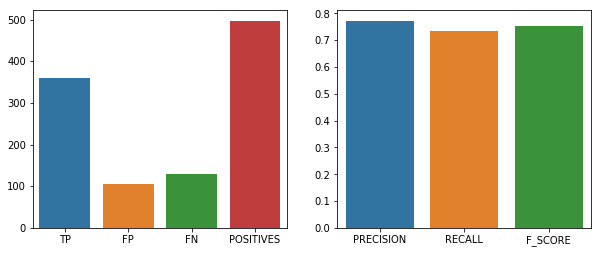

In [9]:
count = 0
def get_count(original_text_list):
    global count
    original_text_list = list(original_text_list)
    count += len(original_text_list)

jj['tp'].apply(lambda x: get_count(x))
tp = count
count = 0
jj['fp'].apply(lambda x: get_count(x))
fp = count
count = 0
jj['fn'].apply(lambda x: get_count(x))
fn = count
count=0
jj['expected'].apply(lambda x: get_count(x))
pos = count

fig, ax = plt.subplots(figsize=(10,4))
x = ['TP', 'FP', 'FN', 'POSITIVES']
y = [tp, fp, fn, pos]
print(tp,fp,fn,pos)
plt.subplot(121)
sns.barplot(x=x, y=y)

x = ['PRECISION', 'RECALL', 'F_SCORE']
prec = float(tp)/(tp+fp)
rec = float(tp)/(tp+fn)

f_score = (2 * prec * rec)/ (prec + rec)
y = [prec, rec, f_score]
plt.subplot(122)
sns.barplot(x=x, y=y)
print(f_score)

### PLOT 2
This plot gives us the number of entities found in each sentence.

This plot gives us a rough sense of how well the classifier is doing on samples with different number of entities.

How well is it performing on samples with one, two, two+ entities.

Find me the nearest railway station. (Entity count 2, ["railway", "station"])

Where is the nearest atm (Entitys count 1, ["atm"])

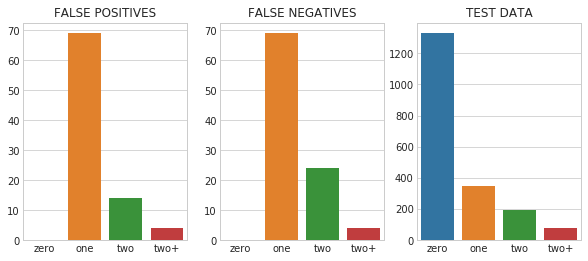

In [10]:
x = [0, 0, 0, 0]
y = ['zero', 'one', 'two', 'two+']
def get_sample_count(original_text_list):
    global x
    count = 0
    for original_text in original_text_list:
        count += len(word_tokenize(original_text))
    if count < len(x):
        x[count] += 1
    else:
        x[-1] += 1

        
        
fig, ax = plt.subplots(figsize=(10,4))



fp_analysis['fp'].apply(lambda x: get_sample_count(list(x)))
np.array(x).sum()
sns.set_style("whitegrid")
plt.subplot(131)
sns.barplot(x=y, y=x)
plt.title('FALSE POSITIVES')

x = [0, 0, 0, 0]
y = ['zero', 'one', 'two', 'two+']
fn_analysis['fn'].apply(lambda x: get_sample_count(list(x)))
np.array(x).sum()
plt.subplot(132)
sns.barplot(x=y, y=x)
plt.title('FALSE NEGATIVES')


x = [0, 0, 0, 0]
y = ['zero', 'one', 'two', 'two+']
X_plot_test['original_text'].apply(lambda x: get_sample_count(list(x)))
np.array(x).sum()
plt.subplot(133)
sns.barplot(x=y, y=x)
plt.title('TEST DATA')
# Show the plot                   
plt.show()


### PLOT 3
This plot gives us the each specific entity occurences

This plot gives us a rough sense of how well the classifier is doing on specific entities.

We can pin point to exact entities if they are consistently getting miscalssified
In the example below Graph 3. There are approximately 60 atm occurences

**Top 7 entities **

Text(0.5,1,'TEST DATA')

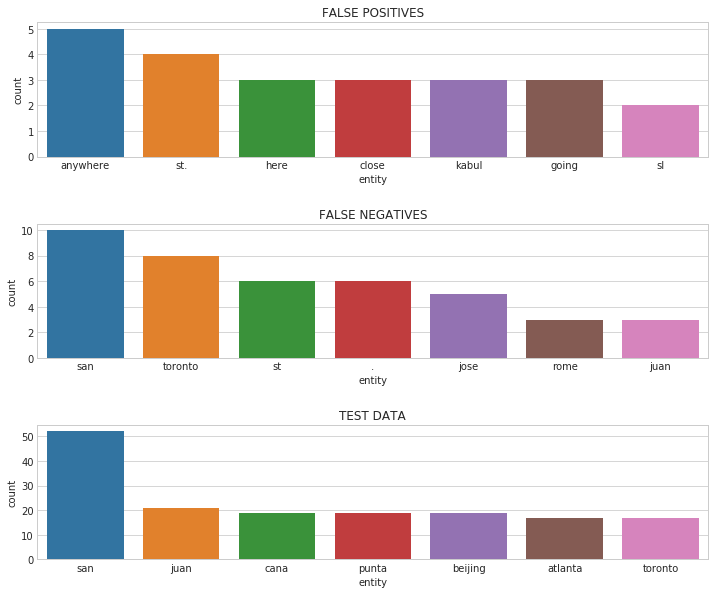

In [11]:
x_dict = {}
def get_entities_count(original_text_list):
    global x_dict
    for original_text in original_text_list:
        original_text_lower = original_text.lower()
        if original_text_lower not in x_dict.keys():
            x_dict[original_text_lower] = 0
        x_dict[original_text_lower] += 1

fig, ax = plt.subplots(figsize=(10,8))

fig.tight_layout()
plt.subplots_adjust(hspace=.5)
fp_analysis['fp'].apply(lambda x: get_entities_count(list(x)))
unique_entity_list = pd.DataFrame({'entity': list(x_dict.keys()), 'count': list(x_dict.values())})
unique_entity_list.sort_values(by='count', ascending=[0], inplace=True)
plt.subplot(311)
sns.barplot(x='entity', y='count', data=unique_entity_list.head(7))
plt.title('FALSE POSITIVES')

x_dict = {}
fn_analysis['fn'].apply(lambda x: get_entities_count(list(x)))
unique_entity_list = pd.DataFrame({'entity': list(x_dict.keys()), 'count': list(x_dict.values())})
unique_entity_list.sort_values(by=['count'], ascending=[0], inplace=True)
plt.subplot(312)
sns.barplot(x='entity', y='count', data=unique_entity_list.head(7))
plt.title('FALSE NEGATIVES')

x_dict = {}
X_plot_test['original_text'].apply(lambda x: get_entities_count(list(x)))
unique_entity_list = pd.DataFrame({'entity': list(x_dict.keys()), 'count': list(x_dict.values())})
unique_entity_list.sort_values(by=['count'], ascending=[0], inplace=True)
plt.subplot(313)
sns.barplot(x='entity', y='count', data=unique_entity_list.head(7))
plt.title('TEST DATA')


### PLOT 4
This plot gives us the each specific word occuring before and after each entity.

This helps us understand the words before and after or inshort the patterns that occur surrounding the entity

We can understand the patterns which are consistently misclassified
START: The entity is at the start of the sentence hence no words before
atm near me

END: The entity is at the end of the sentence hence no words after
nearest atm

ONLY: The sentence only consists of entity alone
pizza hut
**Top 7 entities depicted**

/home/pratik/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/pratik/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/pratik/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

no message
no message
no message
no message
no message
no message
no message
no message
no message
no message
no message
no message
no message
no message
no message
no message
no message
no message
no message
no message
no message
no message
no message


/home/pratik/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/pratik/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/pratik/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

Text(0.5,1,'TEST DATA AFTER')

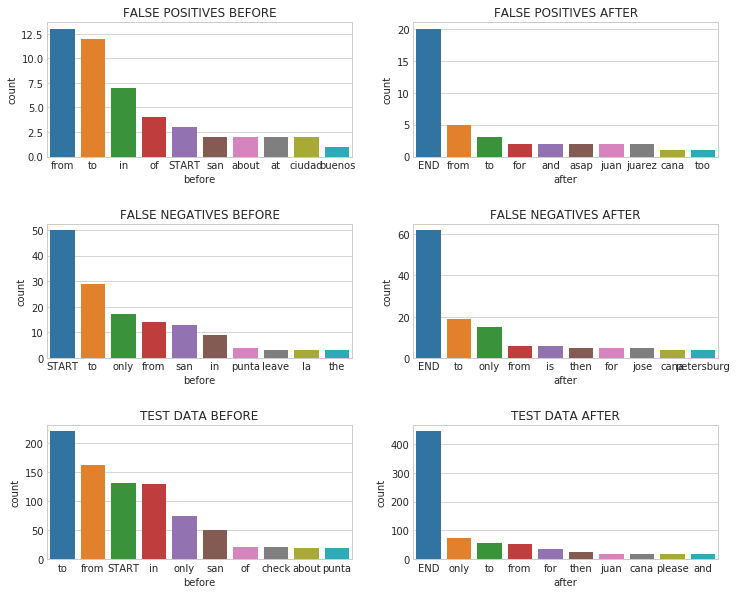

In [12]:
before_dict = {}
after_dict = {}
before_dict['only'] = 0
after_dict['only'] = 0
def get_words_before(text, original_text_list):
    text = ' '.join(text)
    global before_dict, after_dict, only
    only = end_status = start_status = False
    text = text.lower()
    for original_text in original_text_list:
        original_text = original_text.lower()
        regex = re.compile(r'(\w*[,|:|?]*)\s*%s\s*(\w*)' %(original_text))
        before = after = None
        try:
            before, after = regex.findall(text)[0]
        except:
            print(text)
        if not (before or after):
            before_dict['only'] += 1
            after_dict['only'] += 1
            only = True
            
        before = before or 'START'
        after = after or 'END'
        
        if before == 'START':
            start_status = True
        if after == 'END':
            end_status = True
        
        
        if before not in before_dict:
            before_dict[before] = 0
        if after not in after_dict:
            after_dict[after] = 0
        
        before_dict[before] += 1
        after_dict[after] += 1
    return {'s':start_status, 'e': end_status}
fig, ax = plt.subplots(figsize=(10,8))
fig.tight_layout()
plt.subplots_adjust(hspace=.5)
fp_analysis['start_end'] = fp_analysis.apply(lambda x: get_words_before(x['body'], x['expected']), axis=1)       
fp_analysis['start'] = fp_analysis['start_end'].apply(lambda x: x['s'])
fp_analysis['end'] = fp_analysis['start_end'].apply(lambda x: x['e'])
fp_analysis['only'] = fp_analysis.apply(lambda x: x['start'] and x['end'], axis=1)
fp_analysis.drop('start_end', inplace=True, axis=1)
before_pattern_list = pd.DataFrame({'before': list(before_dict.keys()), 'count': list(before_dict.values())})
before_pattern_list.sort_values(by=['count'], ascending=[0], inplace=True)
after_pattern_list = pd.DataFrame({'after': list(after_dict.keys()), 'count':list( after_dict.values())})
after_pattern_list.sort_values(by=['count'], ascending=[0], inplace=True)
plt.subplot(321)
sns.barplot(x='before', y='count', data=before_pattern_list.head(10))
plt.title('FALSE POSITIVES BEFORE')
plt.subplot(322)
sns.barplot(x='after', y='count', data=after_pattern_list.head(10))
plt.title('FALSE POSITIVES AFTER')


before_dict = {}
after_dict = {}
before_dict['only'] = 0
after_dict['only'] = 0


fn_analysis['start_end'] = fn_analysis.apply(lambda x: get_words_before(x['body'], x['expected']), axis=1)       
fn_analysis['start'] = fn_analysis['start_end'].apply(lambda x: x['s'])
fn_analysis['end'] = fn_analysis['start_end'].apply(lambda x: x['e'])
fn_analysis['only'] = fn_analysis.apply(lambda x: x['start'] and x['end'], axis=1)
fn_analysis.drop('start_end', inplace=True, axis=1)
before_pattern_list = pd.DataFrame({'before': list(before_dict.keys()), 'count': list(before_dict.values())})
before_pattern_list.sort_values(by=['count'], ascending=[0], inplace=True)
after_pattern_list = pd.DataFrame({'after': list(after_dict.keys()), 'count': list(after_dict.values())})
after_pattern_list.sort_values(by=['count'], ascending=[0], inplace=True)
plt.subplot(323)
sns.barplot(x='before', y='count', data=before_pattern_list.head(10))
plt.title('FALSE NEGATIVES BEFORE')
plt.subplot(324)
sns.barplot(x='after', y='count', data=after_pattern_list.head(10))
plt.title('FALSE NEGATIVES AFTER')

before_dict = {}
after_dict = {}
before_dict['only'] = 0
after_dict['only'] = 0


X_plot_test['start_end'] = X_plot_test.apply(lambda x: get_words_before([p for p in word_tokenize(x['body'])], x['original_text']), axis=1)       
X_plot_test['start'] = X_plot_test['start_end'].apply(lambda x: x['s'])
X_plot_test['end'] = X_plot_test['start_end'].apply(lambda x: x['e'])
X_plot_test['only'] = X_plot_test.apply(lambda x: x['start'] and x['end'], axis=1)
X_plot_test.drop('start_end', inplace=True, axis=1)

before_pattern_list = pd.DataFrame({'before': list(before_dict.keys()), 'count': list(before_dict.values())})
before_pattern_list.sort_values(by=['count'], ascending=[0], inplace=True)
after_pattern_list = pd.DataFrame({'after': list(after_dict.keys()), 'count': list(after_dict.values())})
after_pattern_list.sort_values(by=['count'], ascending=[0], inplace=True)
plt.subplot(325)
sns.barplot(x='before', y='count', data=before_pattern_list.head(10))
plt.title('TEST DATA BEFORE')

plt.subplot(326)
sns.barplot(x='after', y='count', data=after_pattern_list.head(10))
plt.title('TEST DATA AFTER')

### PLOT 5
This plot gives us the length distribution of the samples

This gives an overview of the model's performance on samples of different lengths

**The length considered here is the number of tokens in a sentence**

FALSE POSITIVE MEDIAN 16.0
FALSE NEGATIVE MEDIAN 13.0
TEST DATA MEDIAN 9.0


Text(0.5,1,'TEST DATA')

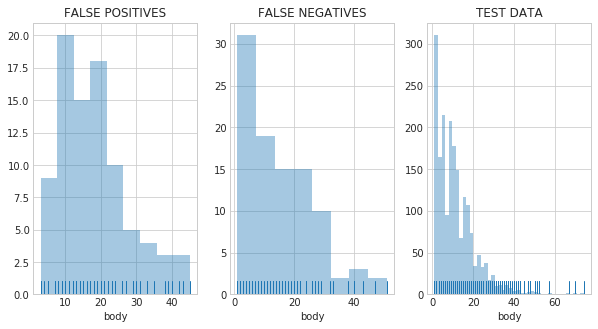

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

print('FALSE POSITIVE MEDIAN', fp_analysis['body'].apply(lambda x: len(x)).median())
plt.subplot(1,3,1)
sns.distplot(fp_analysis['body'].apply(lambda x: len(x)), kde=False, rug=True)
plt.title('FALSE POSITIVES')

plt.subplot(1,3,2)
print('FALSE NEGATIVE MEDIAN', fn_analysis['body'].apply(lambda x: len(x)).median())
sns.distplot(fn_analysis['body'].apply(lambda x: len((x))), kde=False, rug=True)
plt.title('FALSE NEGATIVES')


plt.subplot(1,3,3)
print('TEST DATA MEDIAN', X_plot_test['body'].apply(lambda x: len(word_tokenize(x))).median())
sns.distplot(X_plot_test['body'].apply(lambda x: len(word_tokenize(x))), kde=False, rug=True)
plt.title('TEST DATA')

In [ ]:

def get_count(original_text_list):
    global count
    original_text_list = list(original_text_list)
    count += len(original_text_list)

train_size_analysis = {'train':[], 'train_size': [], 'precision': [], 'recall': [], 'f_score': [] }
train_sizes = [10, 20, 30, 50, 70, 80, 100, 200, 300, 500,600, 800, 1000,1200 , 1500,1700,2000,2200, 2500]
f_score_sizes = []
for train_size in train_sizes:
    count = 0
    print('Running for Train size: ',train_size )
    model = CrfLstmModel( max_sequence_length=MAX_SEQUENCE_LENGTH, 
                         max_char_length=MAX_CHAR_LENGTH,
                         lstm_units=LSTM_UNITS,
                         num_classes=NUM_CLASSES, 
                         epochs=EPOCHS,
                         num_dimensions=NUM_DIMENSIONS,
                         batch_size=BATCH_SIZE,
                         train_len=train_size,
                         lstm_layers=LSTM_LAYERS,
                         layer_parameters=LAYER_PARAMETERS,
                     test_batches=TEST_BATCHES,
                        save_model=SAVE_MODEL
                         , raw_data_path=RAW_DATA_PATH,
                         word_vectors_path=WORD_VECTORS_PATH,
                         words_list_path=WORDS_LIST_PATH)

    jj2 = model.train_test_architecture()
    jj = CrfLstmModel.get_prediction_analysis(jj2)
    jj['tp'].apply(lambda x: get_count(x))
    tp = count
    count = 0
    jj['fp'].apply(lambda x: get_count(x))
    fp = count
    count = 0
    jj['fn'].apply(lambda x: get_count(x))
    fn = count
    count=0
    jj['expected'].apply(lambda x: get_count(x))
    pos = count
    print(tp, fp, fn, pos)
    #print(jj)
    print('---------------------------------------------------------------------------------')
    f_score = 0
    try:
        prec = float(tp)/(tp+fp)
        rec = float(tp)/(tp+fn)
        f_score = (2 * prec * rec)/ (prec + rec)
    except:
        pass
        
    f_score_sizes.append(f_score)
    

Running for Train size:  10


In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
x = train_sizes
y = f_score_sizes

sns.barplot(x=x, y=y)

In [ ]:

def get_count(original_text_list):
    global count
    original_text_list = list(original_text_list)
    count += len(original_text_list)


epoch_sizes = [5,10,15,20,25]
f_score_sizes = []
for epoch_size in epoch_sizes:
    count = 0
    print('Running for Epoch size: ',epoch_size )
    model = CrfLstmModel( max_sequence_length=MAX_SEQUENCE_LENGTH, 
                         max_char_length=MAX_CHAR_LENGTH,
                         lstm_units=LSTM_UNITS,
                         num_classes=NUM_CLASSES, 
                         epochs=epoch_size,
                         num_dimensions=NUM_DIMENSIONS,
                         batch_size=BATCH_SIZE,
                         train_len=TRAIN_LENGTH,
                         lstm_layers=LSTM_LAYERS,
                         layer_parameters=LAYER_PARAMETERS,
                     test_batches=TEST_BATCHES,
                        save_model=SAVE_MODEL
                         , raw_data_path=RAW_DATA_PATH,
                         word_vectors_path=WORD_VECTORS_PATH,
                         words_list_path=WORDS_LIST_PATH)

    jj2 = model.train_test_architecture()
    jj = CrfLstmModel.get_prediction_analysis(jj2)
    jj['tp'].apply(lambda x: get_count(x))
    tp = count
    count = 0
    jj['fp'].apply(lambda x: get_count(x))
    fp = count
    count = 0
    jj['fn'].apply(lambda x: get_count(x))
    fn = count
    count=0
    jj['expected'].apply(lambda x: get_count(x))
    pos = count
    print(tp, fp, fn, pos)
    #print(jj)
    print('---------------------------------------------------------------------------------')
    f_score = 0
    try:
        prec = float(tp)/(tp+fp)
        rec = float(tp)/(tp+fn)
        f_score = (2 * prec * rec)/ (prec + rec)
    except:
        pass
        
    f_score_sizes.append(f_score)
    

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
x = epoch_sizes
y = np.array(f_score_sizes) * 100
print(y)
sns.barplot(x=x, y=y)

In [ ]:
len(model.char_vocab) * (model.max_char_length)